In [10]:
# Libraries
from collections import defaultdict
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.stats as ss
import seaborn.apionly as sns

def getfisher(R, TISSUES):
    O=defaultdict(list)
    Mapdata = {}
    for tis in TISSUES:

        field= 'eSTR.'+SHORTEN[tis]

        # Focus on estrs and motifs
        data = R[["gene","chrom", "str.start","motif",field]]#,"best.score","best.tissue","INTRON"]]
        data_e = data.loc[data[field]>0]
        #
        #frequent_motifs estrs
        Motifs = list(set(list(data_e['motif'])))
        Mo_counts=[list(data['motif']).count(x) for x in Motifs]
        Estr = data_e.shape[0]
        Str = data.shape[0]
        All = []
        # Fisher test for each motif
        for M in Motifs:
            data_eM = data_e.loc[data_e['motif']==M]
            data_M = data.loc[data['motif']==M]
            Mestrs = data_eM.shape[0]
            Mstrs = data_M.shape[0]
            CTT = [[Mestrs, Estr - Mestrs] , [Mstrs-Mestrs , Str-Estr -(Mstrs - Mestrs)]] #contengency
            oddsratio, pv = ss.fisher_exact([CTT[0], CTT[1]])                             #Fisher
            #print ("P (", M, ")    ~~   ",pv*100,"%     with    OR=", oddsratio)
        #
            All.append([M,list(data_e['motif']).count(M),-np.log10(pv),oddsratio])
            O[M].append(oddsratio)
        #
        Mapdata[tis]=All
    # Selecting motifs present in all tissues
    Mset = []
    for o in O.keys():      # O has all the motifs and occurence in tissues
        if len(O[o])>=len(TISSUES):
            Mset.append(o)
    print(len(Mset))
    #heatmap matix
    pdata = np.zeros((len(TISSUES), len(Mset)))
    for i in range(len(TISSUES)):
        T = TISSUES[i]
        for j in range(len(Mset)):
            m=Mset[j]
            val = [s[2] for s in  Mapdata[T] if s[0]==m ]
            if val==[]:
                pdata[i][j] =0
            else:
                pdata[i][j] =val[0]
    return Mset, O,Mapdata, pdata


SHORTEN = {
    "Artery-Aorta":"Artery.A"     ,
    "Artery-Tibial": "Artery.T",
    "Adipose-Subcutaneous": "Adipose.S",    
    "Adipose-Visceral(Omentum)":"Adipose.V",
    "Brain-Caudate(basalganglia)":"Caudate"   , 
    "Brain-Cerebellum":"Cerebellum",
    "Cells-Transformedfibroblasts": "Fibroblast",
    "Esophagus-Mucosa": "Mucosa",
    "Esophagus-Muscularis":"Muscularis",
    "Heart-LeftVentricle":"Ventricule",
    "Lung": "Lung",
    "Muscle-Skeletal": "Muscle",
    "Nerve-Tibial":"Nerve",
    "Skin-NotSunExposed(Suprapubic)": "SkinUnexposed",
    "Skin-SunExposed(Lowerleg)":"SkinLeg",
    "Thyroid":"Thyroid",
    "WholeBlood": "Blood"
}

TISSUES = [item for item in list(SHORTEN.keys())]
regr='/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/LR_SummaryTest_Table.tsv'
feat='/storage/szfeupe/Runs/GTEx_estr/FEATURES/Allgencodefeatures_table'
motif='/storage/resources/dbase/human/hg19/hg19.hipstr_reference_withmotif.bed'
strand= '/storage/resources/dbase/human/hg19/hg19.hipstr_reference_withmotif_stranded.bed'

In [11]:
#open files
FT = pd.read_csv(feat, sep='\t')
#Only work with STR in gene boundary
G = pd.read_csv(regr, sep='\t')  ; X = G[["gene","chrom","str.start","E.tissues"]]
print(G.shape)
FTGene = FT.loc[FT['feature.type']=='gene']
#intersect
Reg = G[['chrom','str.start','str.end','gene','str.id']]; Reg.to_csv('reg.bed', sep='\t',index=None, header=None)
Genes = FTGene[['chrom','start','stop']]; Genes.to_csv('genes.bed', sep='\t',index=None, header=None)
print(Reg.shape, Genes.shape)
cmd = "bedtools intersect -a reg.bed -b genes.bed -wb -names Gene >Intersect.bed"
returned_value = os.system(cmd)
print('Done')
inner = pd.read_csv('Intersect.bed', sep='\t', header=None)
inner.columns=['chrom','str.start','str.end','gene','str.id','chrom_x','gene.start','gene.end']
print(inner.shape)
data = pd.merge(inner[['chrom','str.start','str.end','gene','str.id']], G, on =['chrom','str.start','str.id','gene','str.end'])
data.shape

G=data

S = pd.read_csv(strand, sep='\t', header=None)
S.columns =['chrom','str.start','end','motiflength', 'For_motif','Rev_motif']
G = pd.merge(G, S[['chrom','str.start','For_motif','Rev_motif']], on=['chrom','str.start'], how='inner')
print(G.shape)
#
A = pd.read_csv('/storage/resources/dbase/human/hg19/gencode_gene_annotations_hg19.csv', sep=',')
A['gene']=A['gene.id'];                 A['chrom'] = A['gene.chr']
GG = pd.merge(G, A[['chrom','gene', 'gene.strand']], on=['chrom','gene'])
GG['Motif']=GG['For_motif'].where(GG['gene.strand'] == '+', GG['Rev_motif']) #Strand annotation
del GG['motif']
GG['motif'] = GG['Motif']
print(GG.shape)
Mset,O,Mapdata,pdata = getfisher(GG,TISSUES)
#clustered heatmap by correlation
df1 = pd.DataFrame(pdata)
df1.index = [SHORTEN[t] for t in TISSUES]
df1.columns = Mset


(38365, 59)
(38365, 5) (57820, 3)
Done
(28997, 8)
(28926, 61)
(28926, 63)
20


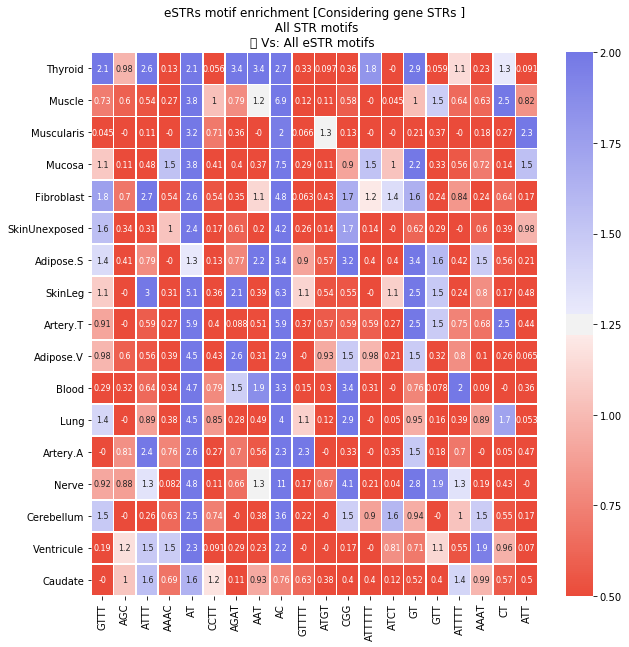

In [13]:
'''
metric="correlation"
Motifs represented here are only those observed across tissues
'''
#plot Enrichrment by strands
fig, ax = plt.subplots(figsize=(10, 10))
cmap = sns.diverging_palette(15, 265, s=80, l=55, n=9, as_cmap=True)    
g = sns.heatmap(df1, cmap=cmap, annot=True, annot_kws={"size": 8},
            vmin=0.5, vmax=2, linewidths=0.5   );
#ax = g.ax_heatmap
#plt.setp(ax.get_yticklabels(), rotation=0)
#plt.setp(ax.get_xticklabels(), rotation=90)
plt.title('eSTRs motif enrichment [Considering gene STRs ]\n  All STR motifs \n\t Vs: All eSTR motifs ')
plt.show()

,chrom,str.start,str.end,gene,str.id,E.tissues,eSTR.Adipose.S,qval.Adipose.S,beta.Adipose.S,eSTR.Adipose.V,...,beta.Thyroid,eSTR.Blood,qval.Blood,beta.Blood,period,motif,For_motif,Rev_motif,gene.strand,Motif
0,chr1,169895824,169895846,ENSG00000000457.9,STR_169895824,0.0,0.0,1.000000,0.000705,0.0,...,-0.067943,0.0,1.000000,0.013130,2,AC,AC,GT,-,GT
1,chr1,169895824,169895846,ENSG00000000460.12,STR_169895824,NaN,0.0,0.000000,0.000000,0.0,...,0.000000,NaN,NaN,NaN,2,AC,AC,GT,+,AC
2,chr1,169667612,169667695,ENSG00000000460.12,STR_169667612,0.0,0.0,0.000000,0.000000,0.0,...,0.179192,0.0,0.428696,0.134485,2,AC,AC,GT,+,AC
3,chr1,169667612,169667695,ENSG00000000460.12,STR_169667612,0.0,0.0,0.000000,0.000000,0.0,...,0.179192,0.0,0.428696,0.134485,2,AC,AC,GT,+,AC
4,chr1,169895824,169895846,ENSG00000075945.8,STR_169895824,NaN,0.0,0.000000,0.000000,0.0,...,0.128134,NaN,NaN,NaN,2,AC,AC,GT,-,GT
5,chr1,169982620,169982660,ENSG00000075945.8,STR_169982620,0.0,1.0,0.075819,-0.205341,0.0,...,0.000000,0.0,0.788976,0.103665,2,AT,AT,AT,-,AT
6,chr1,169667612,169667695,ENSG00000007908.11,STR_169667612,0.0,0.0,1.000000,0.057279,0.0,...,0.000000,0.0,0.752958,-0.088676,2,AC,AC,GT,-,GT
7,chr1,169667612,169667695,ENSG00000007908.11,STR_169667612,0.0,0.0,1.000000,0.057279,0.0,...,0.000000,0.0,0.752958,-0.088676,2,AC,AC,GT,-,GT
8,chr1,169667612,169667695,ENSG00000171806.7,STR_169667612,10.0,1.0,0.013119,0.225821,1.0,...,0.300545,0.0,0.120875,0.156997,2,AC,AC,GT,-,GT
9,chr1,169667612,169667695,ENSG00000171806.7,STR_169667612,10.0,1.0,0.013119,0.225821,1.0,...,0.300545,0.0,0.120875,0.156997,2,AC,AC,GT,-,GT


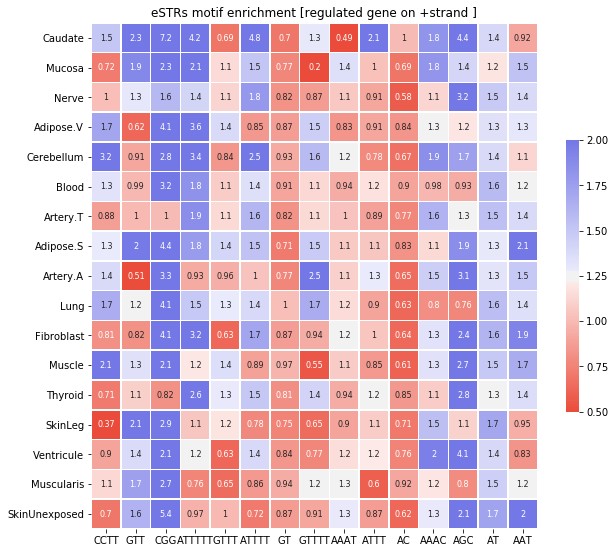

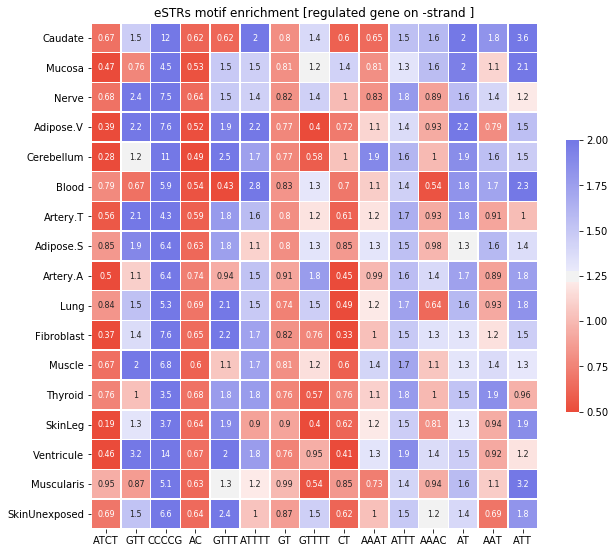

In [7]:
###############################  Strands separately
A = pd.read_csv('/storage/resources/dbase/human/hg19/gencode_gene_annotations_hg19.csv', sep=',')
A['gene']=A['gene.id'];                 A['chrom'] = A['gene.chr']
GG = pd.merge(G, A[['chrom','gene', 'gene.strand']], on=['chrom','gene'])
print(GG.shape)
GG['MOTIF']=GG['motif']
GG['motif']= GG['For_motif'].where(GG['gene.strand'] == '+', GG['Rev_motif'])
print(GG.shape)
print('positive strands')
posGG = GG.loc[GG['gene.strand']=='+']
posMset,Opos,posMapdata,pospdata = getfisher(posGG, TISSUES)
print(posGG.shape, len(posMset))
print('negative strands')
negGG = GG.loc[GG['gene.strand']=='-']
negMset,Oneg,negMapdata,negpdata = getfisher(negGG,TISSUES)
print(negGG.shape,len(negMset))


##Heatmap
#All 
fig, ax = plt.subplots(figsize=(10, 10))
cmap = sns.diverging_palette(15, 265, s=80, l=55, n=9, as_cmap=True)    
sns.heatmap(pdata, cmap=cmap, annot=True, annot_kws={"size": 8},
            vmin=0.5, vmax=2, square=True, ax=ax, linewidths=0.5, cbar_kws={"shrink": 0.5},
           yticklabels=[SHORTEN[t] for t in TISSUES], 
           xticklabels=Mset);
ax.invert_xaxis();
plt.title('eSTRs motif enrichment [STR gene ]')
plt.show()
#plot positive strands
fig, ax = plt.subplots(figsize=(10, 10))
cmap = sns.diverging_palette(15, 265, s=80, l=55, n=9, as_cmap=True)    
sns.heatmap(pospdata, cmap=cmap, annot=True, annot_kws={"size": 8},
            vmin=0.5, vmax=2, square=True, ax=ax, linewidths=0.5, cbar_kws={"shrink": 0.5},
           yticklabels=[SHORTEN[t] for t in TISSUES], 
           xticklabels=posMset);
ax.invert_xaxis();
plt.title('eSTRs motif enrichment [regulated gene on +strand ]')
plt.show()

#plot negative strands
fig, ax = plt.subplots(figsize=(10, 10))
cmap = sns.diverging_palette(15, 265, s=80, l=55, n=9, as_cmap=True)    
sns.heatmap(negpdata, cmap=cmap, annot=True, annot_kws={"size": 8},
            vmin=0.5, vmax=2, square=True, ax=ax, linewidths=0.5, cbar_kws={"shrink": 0.5},
           yticklabels=[SHORTEN[t] for t in TISSUES], 
           xticklabels=negMset);
ax.invert_xaxis();
plt.title('eSTRs motif enrichment [regulated gene on -strand ]')
plt.show()